# Spam vs Ham text classifition with Python

##
###

## Objective
This is a document classification project to classify spam vs ham. I will construct a spam filter to classify text message as ham or spam. 

In [1]:
# import some necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline 
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

## Loading data

In [2]:
# now let's import data in pandas dataframe
df = pd.read_csv('../input/spam.csv',usecols = [0,1],encoding='latin-1' )
df.rename(columns = {'v1':'Category','v2': 'Message'}, inplace = True)

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message ...      
           count ...  freq
Category         ...      
ham         4825 ...    30
spam         747 ...     4

[2 rows x 4 columns]



The initial analysis tells me that there are 4825 ham text and 747 spam text. Most of the messages are unique. The highest repetition in ham text is "Sorry, I'll call later" I am wondering if they keep their words to call back or not. 


## Exporation Data Analysis

First, let's visualize the number of spam text vs. ham text

In [5]:
category_count = pd.DataFrame()
category_count['count'] = df['Category'].value_counts()

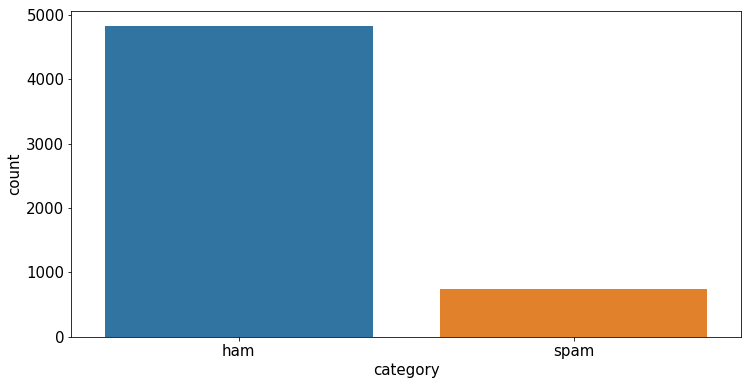

In [6]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('category',fontsize = 15)
ax.tick_params(labelsize=15)

Clearly, this is an **imbalanced dataset**. There are way more ham texts than spam texts here. The typical problem with an imbalanced dataset is that the simple metric like accuracy or precision may not reflect the real performance of predictive models. Since most text are "ham" in this project, even predicting all "ham" will give you **86%**  accuracy. I will go deep into the metric selection in the model construction part.





In [7]:
spam_df = df[df['Category'] == 'spam'] #create sub-dataframe of spam text
ham_df = df[df['Category'] == 'ham'] #sub-dataframe of ham text

In [8]:
stop_words = set(stopwords.words('english'))
def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n]') 
        txt = regex.sub(' ',text)  #remove punctuation
        words = [w for w in txt.split(' ')\
                if not w in stop_words and len(w)>3] # remove stop words and words with length smaller than 3 letters
        return len(words)
    except:
        return 0

In [9]:
spam_df['len'] = spam_df['Message'].apply(lambda x: len([w for w in x.split(' ')]))
ham_df['len'] = ham_df['Message'].apply(lambda x: len([w for w in x.split(' ')]))
spam_df['processed_len'] = spam_df['Message'].apply(lambda x: wordCount(x))
ham_df['processed_len'] = ham_df['Message'].apply(lambda x: wordCount(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p


## Text length distribution analysis

It's interesting to analyze the length distribution of spam and ham texts. I expect the spam text will be longer than ham text since it wants to leave a deep impression on you. Let's check if it's true.

spam length info
              len  processed_len
count  747.000000     747.000000
mean    23.892905      11.068273
std      5.826977       3.128079
min      2.000000       0.000000
25%     22.000000       9.000000
50%     25.000000      11.000000
75%     28.000000      13.000000
max     35.000000      19.000000
ham length info
               len  processed_len
count  4825.000000    4825.000000
mean     14.323938       5.652435
std      11.538966       4.767743
min       1.000000       0.000000
25%       7.000000       3.000000
50%      11.000000       4.000000
75%      19.000000       7.000000
max     171.000000      64.000000


(0, 50)

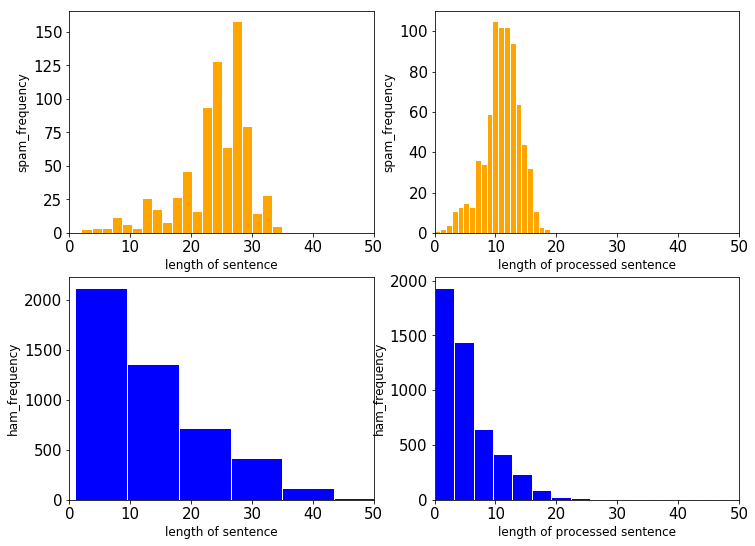

In [10]:
xmin = 0
xmax = 50
print ('spam length info')
print (spam_df[['len', 'processed_len']].describe())
print ('ham length info')
print (ham_df[['len', 'processed_len']].describe())
fig, ((ax,ax1),(ax2,ax3)) = plt.subplots (2,2,figsize = (12,9))
spam_df['len'].plot.hist(bins = 20, ax = ax, edgecolor = 'white', color = 'orange')
spam_df['processed_len'].plot.hist(bins = 20, ax = ax1, edgecolor = 'white', color = 'orange')
ham_df['len'].plot.hist(bins = 20, ax = ax2, edgecolor = 'white', color = 'blue')
ham_df['processed_len'].plot.hist(bins = 20, ax = ax3, edgecolor = 'white', color = 'blue')
ax.tick_params(labelsize = 15)
ax.set_xlabel('length of sentence', fontsize = 12)
ax.set_ylabel('spam_frequency', fontsize = 12)
ax.set_xlim([xmin,xmax])
ax1.tick_params(labelsize = 15)
ax1.set_xlabel('length of processed sentence', fontsize = 12)
ax1.set_ylabel('spam_frequency', fontsize = 12)
ax1.set_xlim([xmin,xmax])
ax2.tick_params(labelsize = 15)
ax2.set_xlabel('length of sentence', fontsize = 12)
ax2.set_ylabel('ham_frequency', fontsize = 12)
ax2.set_xlim([xmin,xmax])
ax3.tick_params(labelsize = 15)
ax3.set_xlabel('length of processed sentence', fontsize = 12)
ax3.set_ylabel('ham_frequency', fontsize = 12)
ax3.set_xlim([xmin,xmax])

These four plots are distributions of spam and ham text before and after precessing. The precessing including removing punctuations and stopwords in English. Also, I removed word with less than 3 letters.

To better compare length distributions, I limited the x scale in the range of (0, 50)

As you can see:

    1. The spam text length distribution is more like normal distribution while the ham text length distribution is right skewed. 
    2. Also, the mean and median of spam text is longer than ham text. This is because usually the spam text include a lot of introduction sentence or tedious information. 
    3. After processing, both spam and ham text are shorter than original length. 

In [11]:
def tokenize(text):
    exclude = set(string.punctuation)
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]') #remove punctuation
    text = regex.sub(' ', text)
    tokens = nltk.word_tokenize(text) # tokenize the text
    tokens = list(filter(lambda x: x.lower() not in stop_words, tokens)) # remove stop words
    tokens = [w.lower() for w in tokens if len(w) >=3] 
    tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
    return tokens

In [12]:
spam_df['tokens'] = spam_df['Message'].map(tokenize)
ham_df['tokens'] = ham_df['Message'].map(tokenize)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Most common words

In this part, I want to check what is the most 10 common words in spam and ham texts. 

In [13]:
spam_words = []
for token in spam_df['tokens']:
    spam_words = spam_words + token #combine text in different columns in one list
ham_words = []
for token in ham_df['tokens']:
    ham_words += token

In [14]:
spam_count = Counter(spam_words).most_common(10)
ham_count = Counter(ham_words).most_common(10)

In [15]:
spam_count_df = pd.DataFrame(spam_count, columns = ['word', 'count'])
ham_count_df = pd.DataFrame(ham_count, columns = ['word', 'count'])

Text(0.5, 1.0, 'ham top 10 words')

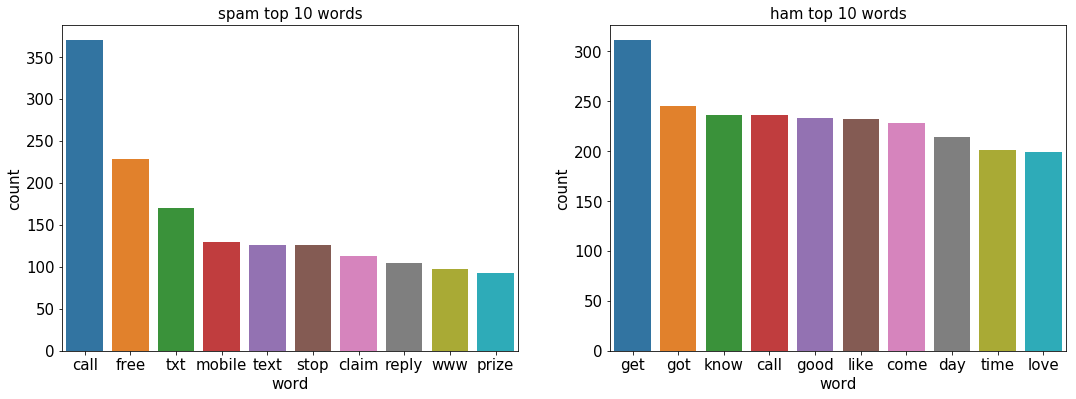

In [16]:
spam_count
fig, (ax,ax1) = plt.subplots(1,2,figsize = (18, 6))
sns.barplot(x = spam_count_df['word'], y = spam_count_df['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('word',fontsize = 15)
ax.tick_params(labelsize=15)
ax.set_title('spam top 10 words', fontsize = 15)
sns.barplot(x = ham_count_df['word'], y = ham_count_df['count'], ax = ax1)
ax1.set_ylabel('count', fontsize = 15)
ax1.set_xlabel('word',fontsize = 15)
ax1.tick_params(labelsize=15)
ax1.set_title('ham top 10 words', fontsize = 15)


**Most common words in spam**

It's not surprise to see many words in this plot are related to communication ("call", "txt", "reply", "mobile", "www"). This is because most spam texts want the receivers to reach back to them. I also see "claim", "prize" and "free" in this list which maybe lead to fraud text

**Most common words in ham**

Many words in ham-common-words list are verbs such as "get", "know" and "come". This is reasonable in a conversation between two people who know each other. Also, I see "day" and "time" which indicates that the texts are used to arrange a meeting. 

## Word cloud

In [17]:
spam_words_str = ' '.join(spam_words)
ham_words_str = ' '.join(ham_words)

In [18]:
spam_word_cloud = WordCloud(width = 600, height = 400, background_color = 'white').generate(spam_words_str)
ham_word_cloud = WordCloud(width = 600, height = 400,background_color = 'white').generate(ham_words_str)

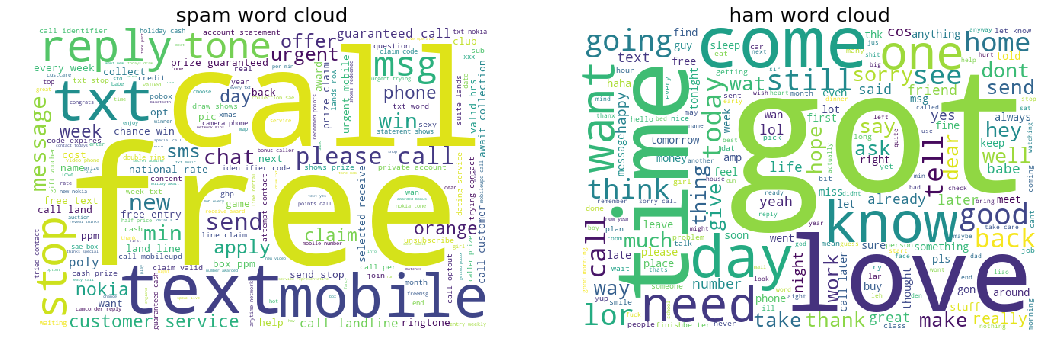

In [19]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (18,8))
ax.imshow(spam_word_cloud)
ax.axis('off')
ax.set_title('spam word cloud', fontsize = 20)
ax2.imshow(ham_word_cloud)
ax2.axis('off')
ax2.set_title('ham word cloud', fontsize = 20)
plt.show()

Word cloud is a straight forward way to demonstrate the most common words in spam and ham text. 

## Modelling

**Convert tokens to a matrix of TF-IDF features**

In [20]:
df['tokens'] = df['Message'].map(tokenize)

In [21]:
def text_join(text):
    return " ".join(text)
df['text'] = df['tokens'].apply(text_join)

In [22]:
tv = TfidfVectorizer('english')
features = tv.fit_transform(df['text'])
target = df.Category.map({'ham':0, 'spam':1})

**import libraries**

In [23]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

**Define a cross validation strategy**

I use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, I add one line of code, in order to shuffle the dataset prior to cross-validation.

For the performance metric, as I mentioned in the beginning, this is an imbalanced dataset. Thus, instead of using accuracy, I used F1-score as metric. F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.



In [24]:
n_folds = 5
def f1_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 29).get_n_splits(features)
    f1 = cross_val_score(model, features, target, scoring = 'f1', cv = kf )
    return (f1)

### Base model

I use **SVC**, **Random Forest**, **Gradient Boosting Classification**, **LightGBM**, and **Multinomial Naive Bayes** as my training model

In [25]:
svc = SVC(kernel = 'sigmoid', gamma = 1.0)
rfc = RandomForestClassifier(n_estimators = 31, random_state = 32)

In [26]:
GBoost = GradientBoostingClassifier( n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5)

In [27]:
model_lgb = lgb.LGBMClassifier(
                              objective='binary',num_leaves=5,
                              learning_rate=0.05, n_estimators=4420,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 1)

In [28]:
mnb = MultinomialNB(alpha = .2)

### Base model scores

Let's see how these base models perform on the data by evaluating the cross-validation f1 score

In [29]:
score = f1_cv(svc)
print ('\nSVC score: {:4f}({:4f})\n'.format(score.mean(), score.std()))


SVC score: 0.889951(0.003906)



In [30]:
score = f1_cv(rfc)
print ('\nRandomForest score: {:4f}({:4f})\n'.format(score.mean(), score.std()))


RandomForest score: 0.902775(0.010004)



In [31]:
score = f1_cv(mnb)
print ('\nMultinomial NB score: {:4f}({:4f})\n'.format(score.mean(), score.std()))


Multinomial NB score: 0.920358(0.022172)



It seems that Gradient Boosting and Multinomial NB perform best with f1-score around 0.92. Now let's see how they perform in accuracy

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [33]:
def classifier(clf, X_train, y_train):    
    clf.fit(X_train, y_train)
def predictor(clf, X_test):
    return (clf.predict(X_test))

In [34]:
clf = {'SVC':svc, 'RandomForest':rfc,  'MultinomialNB': mnb}
preds = []
for key, value in clf.items():
    #print(key)
    classifier(value, X_train, y_train)
    pred = predictor(value,X_test)
    preds.append((key, [accuracy_score(y_test,pred)]))

In [35]:
preds

[('SVC', [0.97188995215311]),
 ('RandomForest', [0.9730861244019139]),
 ('MultinomialNB', [0.9736842105263158])]

All the models have accuracy higher then **97%**. The Multinomial is the best model based on accuracy score (**98%**) and f1 score (**0.921**). Since this is a very small dataset and easy classification problem, I think simple model is enough to filter the spam text. There is no need to use GradientBoost or neural network unless there is a huge dataset need to be classified. 